In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel

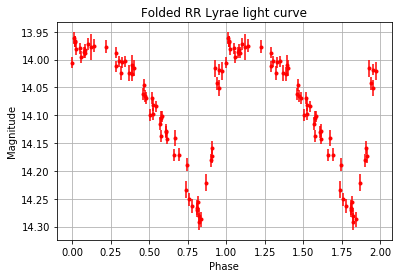

In [2]:
data = np.loadtxt("data/rrl.dat")
P = 0.51194099999999998
mjd, mag, err = data[:, 0], data[:, 1], data[:, 2]
N = len(mjd)
phi = np.mod(mjd, P)/P
I = np.argsort(phi)
phi, mag, err = phi[I], mag[I], err[I]
phi_regular = np.linspace(0, 1, num=100)
plt.errorbar(np.hstack(([phi, phi+1])), 
             np.hstack(([mag, mag])),
             np.hstack(([err, err])), fmt='.', c='r')
plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('Magnitude')
plt.grid()
_ = plt.title('Folded RR Lyrae light curve')

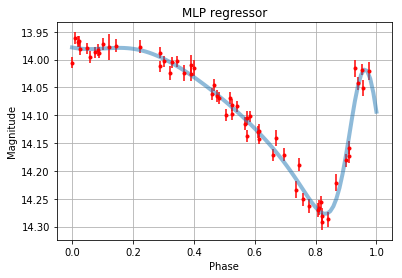

In [3]:
reg = MLPRegressor(hidden_layer_sizes=[10], activation= 'tanh', 
                   solver='lbfgs', learning_rate='constant', tol=1e-8, max_iter=2000)
reg.fit(phi.reshape(-1, 1), (mag - np.mean(mag))/np.std(mag))

mag_regular = reg.predict(phi_regular.reshape(-1, 1))
plt.plot(phi_regular, np.mean(mag)+ np.std(mag)*mag_regular, linewidth=4, alpha=0.5)
plt.errorbar(phi, mag, err, fmt='.', c = 'r')
plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('Magnitude')
plt.grid()
_ = plt.title('MLP regressor')

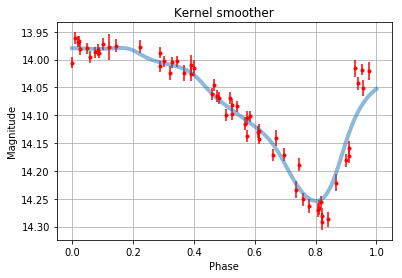

In [4]:
h = 0.05
kappa = np.exp(-0.5*np.power(np.tile(phi, (100, 1)) - np.tile(phi_regular, (N, 1)).T, 2.0)/h**2)
smoother = np.dot(kappa, mag.reshape(-1, 1))[:, 0]/np.sum(kappa, axis=1)
plt.plot(phi_regular, smoother, linewidth=4, alpha=0.5)
plt.errorbar(phi, mag, err, fmt='.', c = 'r')
plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('Magnitude')
plt.grid()
_ = plt.title('Kernel smoother')

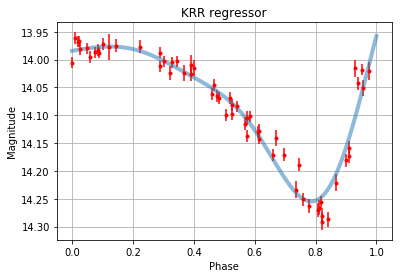

In [5]:
reg = KernelRidge(kernel='rbf', alpha=0.05, gamma=10.0)
reg.fit(phi.reshape(-1, 1), (mag - np.mean(mag))/np.std(mag))
mag_regular = reg.predict(phi_regular.reshape(-1, 1))

plt.plot(phi_regular, np.mean(mag)+ np.std(mag)*mag_regular, linewidth=4, alpha=0.5)
plt.errorbar(phi, mag, err, fmt='.', c = 'r')
plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('Magnitude')
plt.grid()
_ = plt.title('KRR regressor')

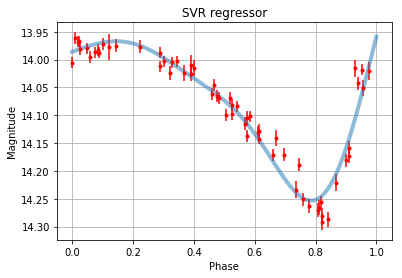

In [6]:
reg = SVR(kernel='rbf', epsilon=0.2, C=10.0, gamma=10.0, tol=1e-6)
reg.fit(phi.reshape(-1, 1), (mag - np.mean(mag))/np.std(mag))
mag_regular = reg.predict(phi_regular.reshape(-1, 1))

plt.plot(phi_regular, np.mean(mag)+ np.std(mag)*mag_regular, linewidth=4, alpha=0.5)
plt.errorbar(phi, mag, err, fmt='.', c = 'r')
plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('Magnitude')
plt.grid()
_ = plt.title('SVR regressor')

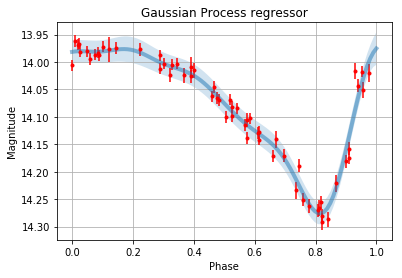

In [7]:
reg = GaussianProcessRegressor(alpha=1e-10, kernel=ExpSineSquared()+ WhiteKernel(), 
                               n_restarts_optimizer=10, normalize_y=False)

reg.fit(phi.reshape(-1, 1), (mag - np.mean(mag))/np.std(mag))
mag_regular, mag_regular_std = reg.predict(phi_regular.reshape(-1, 1), return_std=True)

plt.plot(phi_regular, np.mean(mag)+ np.std(mag)*mag_regular, linewidth=4, alpha=0.5)
plt.fill_between(phi_regular, 
                 np.mean(mag)+np.std(mag)*(mag_regular - mag_regular_std), 
                 np.mean(mag)+np.std(mag)*(mag_regular + mag_regular_std), linewidth=4, alpha=0.2)
plt.errorbar(phi, mag, err, fmt='.', c = 'r')
plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('Magnitude')
plt.grid()
_ = plt.title('Gaussian Process regressor')